**Aluno: Danilo Henrique Achcar**<br/>
**RM: 351516**

# Introdução
Este notebook contém uma série de análises preparadas para serem utilizadas no Streamlit. Ele começa estabelecendo uma conexão com o Google Cloud Platform (GCP) BigQuery, onde consulta os dados relevantes do projeto. Em seguida, esses dados são recuperados para um ambiente Spark local para processamento eficiente. Após essa etapa, os dados são convertidos para o formato Pandas para facilitar a manipulação e a segmentação. Posteriormente, são realizadas análises detalhadas e são criados gráficos para uma melhor visualização dos padrões e tendências nos dados. Essas análises são então exportadas para arquivos em formato .csv.

Por fim, o notebook se concentra na criação de modelos preditivos. Utilizando a técnica de ensemble, são desenvolvidos modelos XGBoost para prever determinadas variáveis. Além disso, são implementados modelos de agrupamento não supervisionado, como KMeans, para identificar padrões intrínsecos nos dados que podem não ser óbvios à primeira vista.

# 1) Instalando dependências externas

In [ ]:
!pip install pyspark
!pip install google-cloud-bigquery
!pip install pywaffle
!pip install missingno

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=4474de7ec478bc79868d5b0a387a1d87f956a2fbc4630495fa3f524454e5334b
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.6/25.6 MB 15.2 MB/s eta 0:00:00


In [ ]:
from google.colab import auth
from google.colab import data_table
from google.cloud import bigquery
from google.colab import userdata
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pywaffle import Waffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, adjusted_rand_score, silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import missingno as msno
import warnings
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

**COMENTÁRIO:** A variável abaixo tem o objetivo de servir como uma constante para ativar ou desativar a consulta de jobs por ID no BigQuery. Mantive ele desativado para o notebook não estourar erros durante a execução, caso o job já tenha expirado (24H).

In [ ]:
# constante para ativar a consulta de jobs no BigQuery
ATIVAR_CONSULTA_VIA_JOBID_BIGQUERY = False

# 2) Google BigQuery
**COMENTÁRIO:** Nesta seção, conectamos ao GCP e BigQuery e consultamos diversas tabelas de lá para dentro de um Spark local. Após essa consulta inicial, transformamos os dataframs Spark em dataframes Pandas.

## 2.1) Login na GCP
**COMENTÁRIO:** Neste bloco, utilizo a API de Secrets do Colabs. Existem 2 variáveis configuradas com os valores para conexão do GCP, respectivamente o nome do projeto e o schema dentro do BigQuery.

In [ ]:
# estabelece a conexão com GCP Big Query
project = userdata.get('fiap-postech-techchallenge3-gcp-project-id')
schema = userdata.get('fiap-postech-techchallenge3-gcp-schema-id')
location = 'US'
client = bigquery.Client(project = project, location = location)
data_table.enable_dataframe_formatter()

auth.authenticate_user()

## 2.2) Conversão de dados BigQuery > Spark > Pandas

In [ ]:
# consulta todos os registros das tabelas de processados e auxiliares no Big Query e cria seus respectivos dataframes do pandas
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_processado
''')
df_pnad = query_job.result().to_dataframe()

In [ ]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_capital
''')
df_capital = query_job.result().to_dataframe()
df_capital.id = df_capital.id.astype(int)

In [ ]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_escolaridade
''')
df_escolaridade = query_job.result().to_dataframe()
df_escolaridade.id = df_escolaridade.id.astype(int)

In [ ]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_medida_restricao
''')
df_medida_restricao = query_job.result().to_dataframe()
df_medida_restricao.id = df_medida_restricao.id.astype(int)

In [ ]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_raca
''')
df_raca = query_job.result().to_dataframe()
df_raca.id = df_raca.id.astype(int)

In [ ]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_regiao_metropolitana
''')
df_regiao_metropolitana = query_job.result().to_dataframe()
df_regiao_metropolitana.id = df_regiao_metropolitana.id.astype(int)

In [ ]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_resultado
''')
df_resultado_exame = query_job.result().to_dataframe()
df_resultado_exame.id = df_resultado_exame.id.astype(int)

In [ ]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_resposta
''')
df_resposta = query_job.result().to_dataframe()
df_resposta.id = df_resposta.id.astype(int)

In [ ]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_sexo
''')
df_sexo = query_job.result().to_dataframe()
df_sexo.id = df_sexo.id.astype(int)

In [ ]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_situacao_domicilio
''')
df_situacao_domicilio = query_job.result().to_dataframe()
df_situacao_domicilio.id = df_situacao_domicilio.id.astype(int)

In [ ]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_tipo_area
''')
df_tipo_area = query_job.result().to_dataframe()
df_tipo_area.id = df_tipo_area.id.astype(int)

In [ ]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_uf
''')
df_uf = query_job.result().to_dataframe()
df_uf.id = df_uf.id.astype(int)

## 2.3) Tratamento dos dados vindos do BigQuery

In [ ]:
df_pnad.shape

(1149197, 31)

In [ ]:
df_pnad.head()

,uf,capital,regiao_metropolitana,semana_mes_v1012,mes_v1013,situacao_domicilio_v1022,tipo_area_v1023,morador_idade_a002,morador_sexo_a003,morador_raca_a004,...,sintoma_perda_olfato_b00111,sintoma_dor_muscular_b00112,sintoma_diarreia_b00113,compareceu_estabelecimento_saude_b002,sedado_entubado_b006,tem_plano_saude_b007,resultado_exame_b009b,medida_restricao_contato_b011,trabalhou_remoto_c013,recebeu_auxilio_emergencial_d0051
0,11,11,<NA>,1,11,1,1,0,2,1,...,2,2,2,<NA>,<NA>,2,<NA>,3,<NA>,2
1,11,11,<NA>,3,11,1,1,6,2,1,...,2,2,2,<NA>,<NA>,2,<NA>,4,<NA>,1
2,11,11,<NA>,1,11,1,1,12,2,4,...,2,2,2,<NA>,<NA>,1,<NA>,4,<NA>,2
3,11,11,<NA>,1,11,1,1,8,1,1,...,2,2,2,<NA>,<NA>,1,<NA>,4,<NA>,2
4,11,11,<NA>,4,11,1,1,6,1,4,...,2,2,2,<NA>,<NA>,2,<NA>,3,<NA>,2


In [ ]:
df_pnad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149197 entries, 0 to 1149196
Data columns (total 31 columns):
 #   Column                                 Non-Null Count    Dtype
---  ------                                 --------------    -----
 0   uf                                     1149197 non-null  Int64
 1   capital                                270626 non-null   Int64
 2   regiao_metropolitana                   363972 non-null   Int64
 3   semana_mes_v1012                       1149197 non-null  Int64
 4   mes_v1013                              1149197 non-null  Int64
 5   situacao_domicilio_v1022               1149197 non-null  Int64
 6   tipo_area_v1023                        1149197 non-null  Int64
 7   morador_idade_a002                     1149197 non-null  Int64
 8   morador_sexo_a003                      1149197 non-null  Int64
 9   morador_raca_a004                      1149197 non-null  Int64
 10  morador_escolaridade_a005              1149197 non-null  Int64
 11

In [ ]:
# verificando quais colunas possuem registros nulos
df_pnad.isnull().sum()

uf                                             0
capital                                   878571
regiao_metropolitana                      785225
semana_mes_v1012                               0
mes_v1013                                      0
situacao_domicilio_v1022                       0
tipo_area_v1023                                0
morador_idade_a002                             0
morador_sexo_a003                              0
morador_raca_a004                              0
morador_escolaridade_a005                      0
sintoma_febre_b0011                            0
sintoma_tosse_b0012                            0
sintoma_dor_garganta_b0013                     0
sintoma_dificuldade_respiracao_b0014           0
sintoma_dor_cabeca_b0015                       0
sintoma_dor_peito_b0016                        0
sintoma_nausea_b0017                           0
sintoma_nariz_entupido_b0018                   0
sintoma_fadiga_b0019                           0
sintoma_dor_olhos_b0

<Axes: >

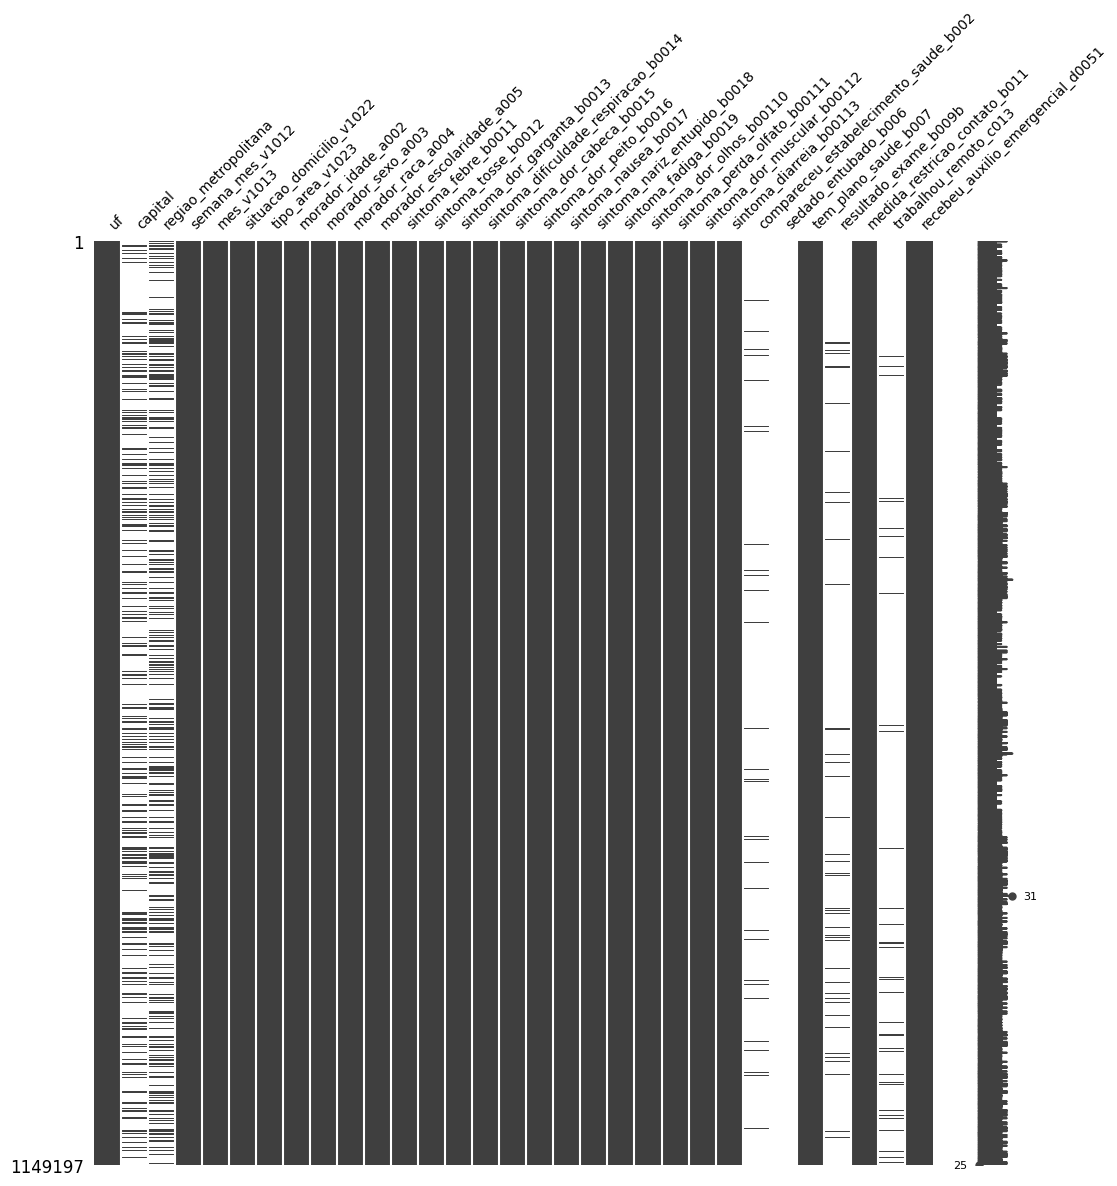

In [ ]:
# utilizando a biblioteca missingno para visualizar as colunas nulas
msno.matrix(df_pnad, figsize=(12, 12), fontsize=10)

In [ ]:
# verificando quais são as respostas possíveis
df_resposta

,id,nome
0,9,Ignorado
1,2,Não
2,3,Não sabe
3,1,Sim


In [ ]:
# verificando quais são os resultados possíveis
df_resultado_exame

,id,nome
0,3,Inconclusivo
1,1,Positivo
2,2,Negativo
3,4,Ainda não recebeu o resultado
4,9,Ignorado


In [ ]:
# define que todos valores nulos receberão o valor 9 (IGNORADO)
df_pnad['compareceu_estabelecimento_saude_b002'] = df_pnad['compareceu_estabelecimento_saude_b002'].fillna(9)
df_pnad['sedado_entubado_b006'] = df_pnad['sedado_entubado_b006'].fillna(9)
df_pnad['trabalhou_remoto_c013'] = df_pnad['trabalhou_remoto_c013'].fillna(9)
df_pnad['resultado_exame_b009b'] = df_pnad['resultado_exame_b009b'].fillna(9)

<Axes: >

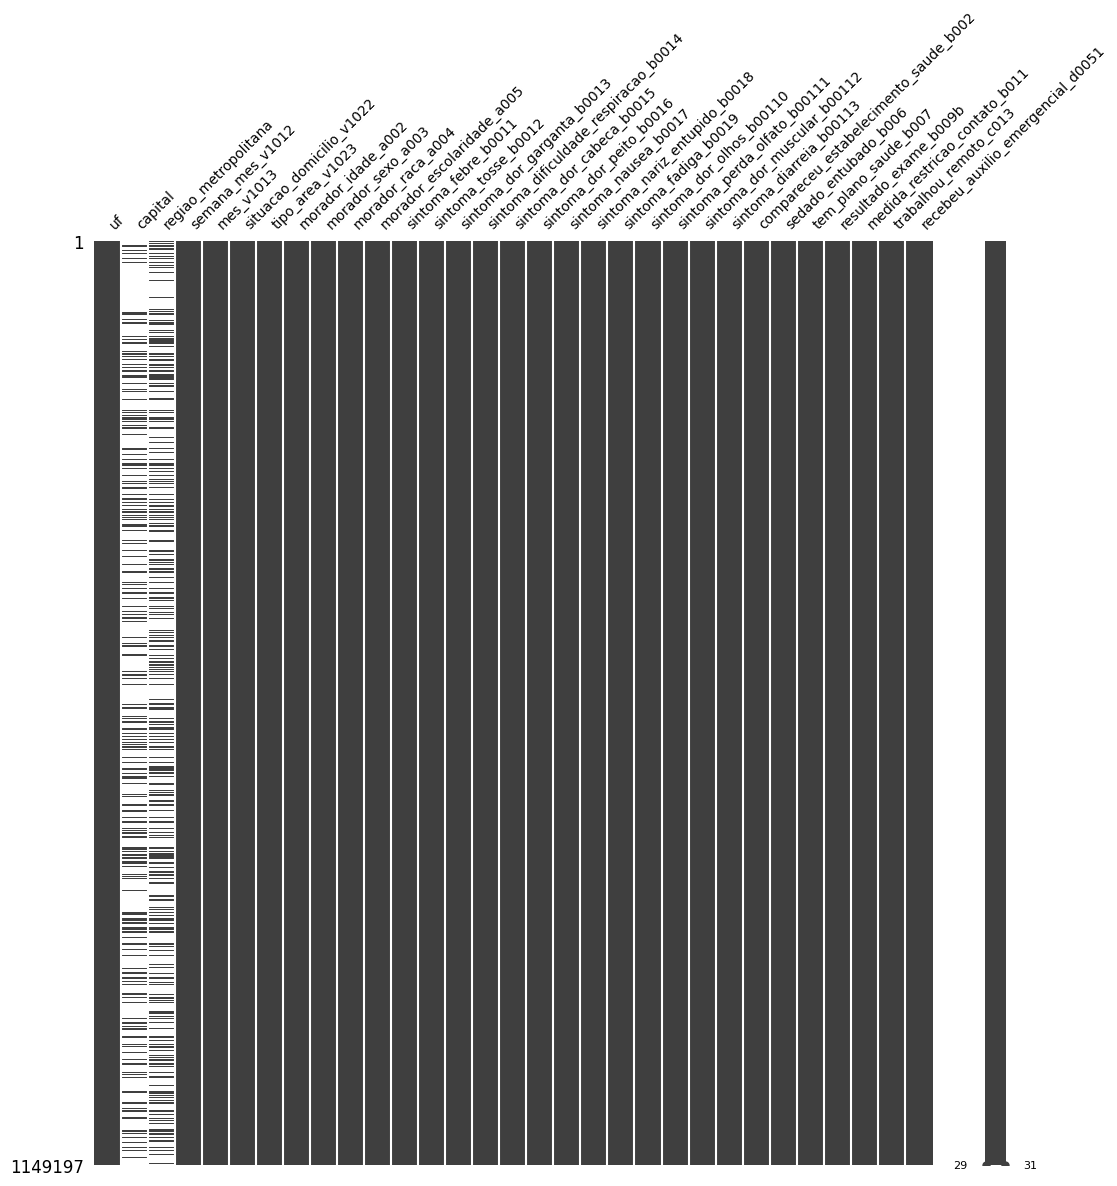

In [ ]:
# verificando a tabela de nulos para ver como ficou a distribuição
msno.matrix(df_pnad, figsize=(12, 12), fontsize=10)

## 2.4) Conversão do Pandas de volta para o Spark (para fins de validação)

In [ ]:
# cria um schema do Spark para conversão do dataframe do pandas num dataframe do Spark
schema = StructType([StructField(x, IntegerType(), True) for x in df_pnad.columns])

In [ ]:
# cria a sessão no Spark
spark = SparkSession.builder.master("local[*]").getOrCreate()
# converte o dataframe do pandas com o schema previamente criado num dataframe do Spark
df_pnad_spark = spark.createDataFrame(df_pnad, schema=schema, verifySchema=False)
# cria uma view da PNAD dentro do contexto do Spark
df_pnad_spark.createOrReplaceTempView('pnad')

In [ ]:
# verificando a quantidade de registros no dataframe Spark
print(df_pnad_spark.count())

1149197


In [ ]:
# verificando a quantidade de registros na view (deve bater com as outras contagens)
spark.sql('''
  SELECT COUNT(1) as total
  FROM pnad
''').show()

+-------+
|  total|
+-------+
|1149197|
+-------+



In [ ]:
df_pnad_spark.printSchema()

root
 |-- uf: integer (nullable = true)
 |-- capital: integer (nullable = true)
 |-- regiao_metropolitana: integer (nullable = true)
 |-- semana_mes_v1012: integer (nullable = true)
 |-- mes_v1013: integer (nullable = true)
 |-- situacao_domicilio_v1022: integer (nullable = true)
 |-- tipo_area_v1023: integer (nullable = true)
 |-- morador_idade_a002: integer (nullable = true)
 |-- morador_sexo_a003: integer (nullable = true)
 |-- morador_raca_a004: integer (nullable = true)
 |-- morador_escolaridade_a005: integer (nullable = true)
 |-- sintoma_febre_b0011: integer (nullable = true)
 |-- sintoma_tosse_b0012: integer (nullable = true)
 |-- sintoma_dor_garganta_b0013: integer (nullable = true)
 |-- sintoma_dificuldade_respiracao_b0014: integer (nullable = true)
 |-- sintoma_dor_cabeca_b0015: integer (nullable = true)
 |-- sintoma_dor_peito_b0016: integer (nullable = true)
 |-- sintoma_nausea_b0017: integer (nullable = true)
 |-- sintoma_nariz_entupido_b0018: integer (nullable = true)
 |-

In [ ]:
df_pnad_spark.show(5)

+---+-------+--------------------+----------------+---------+------------------------+---------------+------------------+-----------------+-----------------+-------------------------+-------------------+-------------------+--------------------------+------------------------------------+------------------------+-----------------------+--------------------+----------------------------+--------------------+------------------------+---------------------------+---------------------------+-----------------------+-------------------------------------+--------------------+--------------------+---------------------+-----------------------------+---------------------+---------------------------------+
| uf|capital|regiao_metropolitana|semana_mes_v1012|mes_v1013|situacao_domicilio_v1022|tipo_area_v1023|morador_idade_a002|morador_sexo_a003|morador_raca_a004|morador_escolaridade_a005|sintoma_febre_b0011|sintoma_tosse_b0012|sintoma_dor_garganta_b0013|sintoma_dificuldade_respiracao_b0014|sintoma_dor_

# 3) Segmentando o público
**COMENTÁRIO:** Devido às restrições de processamento do Google Colab e à praticidade oferecida pelo Pandas, as análises a seguir serão realizadas utilizando esta biblioteca em vez do Spark. Embora o Spark seja uma opção viável para processamento distribuído em ambientes com maior capacidade de processamento, como o Google Colab Pro ou serviços em nuvem, sua adoção implicaria em custos adicionais para o projeto, os quais foram considerados indesejáveis e, portanto, evitados no decorrer deste projeto.

<Axes: xlabel='morador_idade_a002', ylabel='Count'>

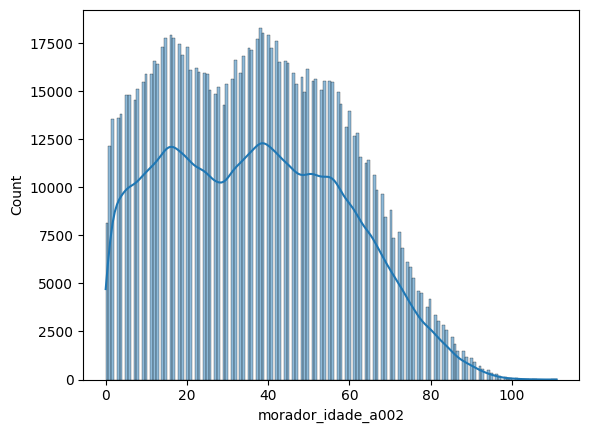

In [ ]:
sns.histplot(data=df_pnad, x='morador_idade_a002', kde=True)

array([[<Axes: title={'center': 'resultado_exame_b009b'}>,
        <Axes: title={'center': 'morador_idade_a002'}>]], dtype=object)

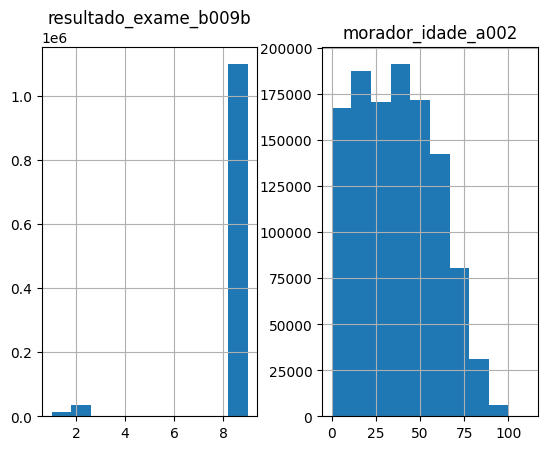

In [ ]:
df_pnad[['resultado_exame_b009b', 'morador_idade_a002']].hist()

## 3.1) Sexo

In [ ]:
df_sexo

,id,nome
0,2,Mulher
1,1,Homem


In [ ]:
# testando manualmente
total_homens = len(df_pnad[df_pnad['morador_sexo_a003'] == 1])
total_mulheres = len(df_pnad[df_pnad['morador_sexo_a003'] == 2])

print(f'Homens: {total_homens}')
print(f'Mulheres: {total_mulheres}')

Homens: 550656
Mulheres: 598541


In [ ]:
# preparando o dataframe segmentado
sexo_segmentado = df_pnad['morador_sexo_a003'].value_counts() # faz a contagem por categoria (sexo)
df_pnad_sexo = pd.DataFrame({'id': sexo_segmentado.index, 'total': sexo_segmentado.values})
df_pnad_sexo = pd.merge(df_pnad_sexo, df_sexo, on='id', how='inner')
df_pnad_sexo.to_csv('segmentacao-sexo.csv', index=False)
df_pnad_sexo.head()

,id,total,nome
0,2,598541,Mulher
1,1,550656,Homem


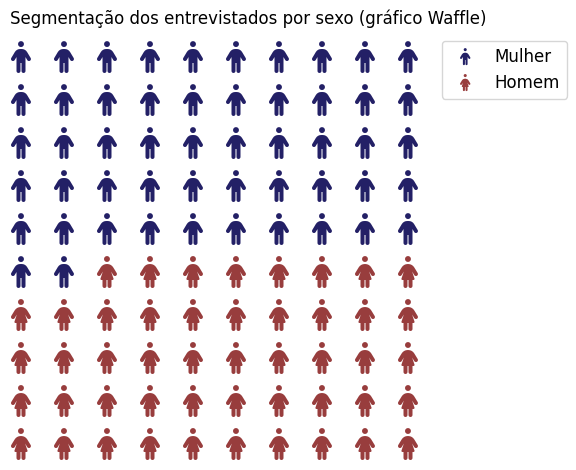

In [ ]:
sexo_cores = ['#983D3D', '#232066']
waffle_icons = ['person', 'person-dress']

fig = go.Figure()
fig.add_trace(go.Pie(labels=df_pnad_sexo.nome, values=df_pnad_sexo.total, hole=.65, marker=dict(colors=sexo_cores)))
fig.update_layout(title='Segmentação dos entrevistados por sexo')
fig.show()

fig = plt.figure(
    FigureClass=Waffle,
    rows=10,
    columns=10,
    vertical=True,
    starting_location='NW',
    icons=waffle_icons,
    icon_legend =True,
    labels=df_pnad_sexo.nome.values.tolist(),
    values=df_pnad_sexo.total.values.tolist(),
    colors=sexo_cores[::-1],
    title={'label': 'Segmentação dos entrevistados por sexo (gráfico Waffle)', 'loc': 'left'},
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1), 'fontsize': 12},
    plot_anchor='C'
)
plt.show()

## 3.2) Estado

In [ ]:
# preparando o dataframe segmentado
uf_segmentado = df_pnad['uf'].value_counts() # faz a contagem por categoria (uf)
df_pnad_uf = pd.DataFrame({'id': uf_segmentado.index, 'total': uf_segmentado.values})
df_pnad_uf = pd.merge(df_pnad_uf, df_uf, on='id', how='inner')
df_pnad_uf.to_csv('segmentacao-uf.csv', index=False)
df_pnad_uf.head()

,id,total,nome
0,31,103096,Minas Gerais
1,35,98021,São Paulo
2,33,87405,Rio de Janeiro
3,42,70990,Santa Catarina
4,43,66446,Rio Grande do Sul


In [ ]:
# plot do gráfico
fig = go.Figure()
fig.add_trace(go.Bar(x=df_pnad_uf.nome.tolist(), y=df_pnad_uf.total.tolist()))
fig.update_layout(title='Segmentação dos entrevistados por UF')
fig.show()

## 3.3) Região metropolitana

In [ ]:
# preparando o dataframe segmentado
regiao_metropolitana_segmentado = df_pnad['regiao_metropolitana'].value_counts() # faz a contagem por categoria (região metropolitana)
df_pnad_regiao_metropolitana = pd.DataFrame({'id': regiao_metropolitana_segmentado.index, 'total': regiao_metropolitana_segmentado.values})
df_pnad_regiao_metropolitana = pd.merge(df_pnad_regiao_metropolitana, df_regiao_metropolitana, on='id', how='inner')
df_pnad_regiao_metropolitana.to_csv('segmentacao-regiao-metropolitana.csv', index=False)
df_pnad_regiao_metropolitana.head()

,id,total,nome
0,33,58590,Região Metropolitana de Rio de Janeiro (RJ)
1,35,38160,Região Metropolitana de São Paulo (SP)
2,31,27963,Região Metropolitana de Belo Horizonte (MG)
3,32,22172,Região Metropolitana de Grande Vitória (ES)
4,43,21924,Região Metropolitana de Porto Alegre (RS)


In [ ]:
# plot do gráfico
fig = go.Figure()
fig.add_trace(go.Bar(x=df_pnad_regiao_metropolitana.nome.tolist(), y=df_pnad_regiao_metropolitana.total.tolist()))
fig.update_layout(title='Segmentação dos entrevistados por região metropolitana')
fig.show()

## 3.4) Escolaridade

In [ ]:
# preparando o dataframe segmentado
escolaridade_segmentado = df_pnad['morador_escolaridade_a005'].value_counts() # faz a contagem por categoria (escolaridade)
df_pnad_escolaridade = pd.DataFrame({'id': escolaridade_segmentado.index, 'total': escolaridade_segmentado.values})
df_pnad_escolaridade = pd.merge(df_pnad_escolaridade, df_escolaridade, on='id', how='inner')
df_pnad_escolaridade.to_csv('segmentacao-escolaridade.csv', index=False)
df_pnad_escolaridade.head()

,id,total,nome
0,2,387986,Fundamental incompleto
1,5,256040,Médio completo
2,1,124035,Sem instrução
3,4,107635,Médio incompleto
4,7,107441,Superior completo


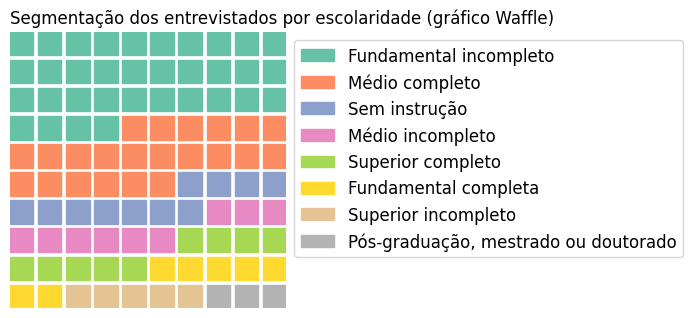

In [ ]:
# plot dos gráficos
fig = go.Figure()
fig.add_trace(go.Pie(labels=df_pnad_escolaridade.nome.tolist(), values=df_pnad_escolaridade.total.tolist(), hole=.65))
fig.update_layout(title='Segmentação dos entrevistados por escolaridade')
fig.show()

fig = plt.figure(
    FigureClass=Waffle,
    rows=10,
    columns=10,
    vertical=True,
    starting_location='NW',
    labels=df_pnad_escolaridade.nome.tolist(),
    values=df_pnad_escolaridade.total.tolist(),
    title={'label': 'Segmentação dos entrevistados por escolaridade (gráfico Waffle)', 'loc': 'left'},
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1), 'fontsize': 12},
    plot_anchor='C'
)
plt.show()

## 3.5) Idade

In [ ]:
# preparando o dataframe segmentado
idade_segmentado = df_pnad['morador_idade_a002'].value_counts(bins=[0, 18, 35, 50, 65, 80, 120], sort=False) # faz a contagem por categoria (faixa de idade)
df_pnad_idade = pd.DataFrame({'nome': idade_segmentado.index, 'total': idade_segmentado.values})
df_pnad_idade.to_csv('segmentacao-idade.csv', index=False)
df_pnad_idade.head()

,nome,total
0,"(-0.001, 18.0]",288774
1,"(18.0, 35.0]",271310
2,"(35.0, 50.0]",251661
3,"(50.0, 65.0]",208806
4,"(65.0, 80.0]",103593


In [ ]:
df_pnad_idade.nome.astype(str)

0    (-0.001, 18.0]
1      (18.0, 35.0]
2      (35.0, 50.0]
3      (50.0, 65.0]
4      (65.0, 80.0]
5     (80.0, 120.0]
Name: nome, dtype: object

In [ ]:
# plot do gráfico
faixas_etarias = df_pnad_idade.nome.values.astype(str)
populacao = df_pnad_idade.total.values

fig = go.Figure(go.Bar(
            x=populacao,
            y=faixas_etarias,
            orientation='h'))

fig.update_layout(title='Segmentação dos entrevistados por faixa etária',
                  xaxis_title='Número de indivíduos',
                  yaxis_title='Faixas etárias')

fig.show()

## 3.6) Tem plano de sáude?

In [ ]:
# preparando o dataframe segmentado
plano_saude_segmentado = df_pnad['tem_plano_saude_b007'].value_counts() # faz a contagem por categoria (plano de saúde)
df_pnad_plano_saude = pd.DataFrame({'id': plano_saude_segmentado.index, 'total': plano_saude_segmentado.values})
df_pnad_plano_saude = pd.merge(df_pnad_plano_saude, df_resposta, on='id', how='inner')
df_pnad_plano_saude.to_csv('segmentacao-plano-saude.csv', index=False)
df_pnad_plano_saude.head()

,id,total,nome
0,2,886199,Não
1,1,260528,Sim
2,9,2470,Ignorado


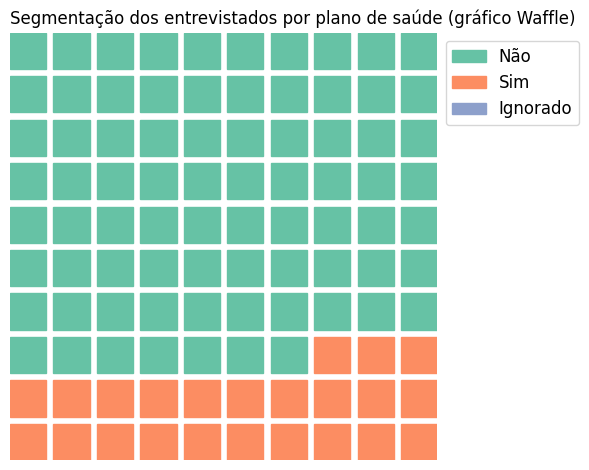

In [ ]:
# plot dos gráficos
fig = go.Figure()
fig.add_trace(go.Pie(labels=df_pnad_plano_saude.nome, values=df_pnad_plano_saude.total, hole=.65))
fig.update_layout(title='Segmentação dos entrevistados por plano de saúde')
fig.show()

fig = plt.figure(
    FigureClass=Waffle,
    rows=10,
    columns=10,
    vertical=True,
    starting_location='NW',
    labels=df_pnad_plano_saude.nome.tolist(),
    values=df_pnad_plano_saude.total.tolist(),
    title={'label': 'Segmentação dos entrevistados por plano de saúde (gráfico Waffle)', 'loc': 'left'},
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1), 'fontsize': 12},
    plot_anchor='C'
)
plt.show()

## 3.7) Sintomas mais comuns

In [ ]:
df_resposta

,id,nome
0,9,Ignorado
1,2,Não
2,3,Não sabe
3,1,Sim


In [ ]:
# seleciona apenas colunas com os sintomas
colunas_sintomas = ['sintoma_febre_b0011',
       'sintoma_tosse_b0012', 'sintoma_dor_garganta_b0013',
       'sintoma_dificuldade_respiracao_b0014', 'sintoma_dor_cabeca_b0015',
       'sintoma_dor_peito_b0016', 'sintoma_nausea_b0017',
       'sintoma_nariz_entupido_b0018', 'sintoma_fadiga_b0019',
       'sintoma_dor_olhos_b00110', 'sintoma_perda_olfato_b00111',
       'sintoma_dor_muscular_b00112', 'sintoma_diarreia_b00113']
df_pnad_sintomas = df_pnad[colunas_sintomas]

In [ ]:
df_pnad_sintomas.head()

,sintoma_febre_b0011,sintoma_tosse_b0012,sintoma_dor_garganta_b0013,sintoma_dificuldade_respiracao_b0014,sintoma_dor_cabeca_b0015,sintoma_dor_peito_b0016,sintoma_nausea_b0017,sintoma_nariz_entupido_b0018,sintoma_fadiga_b0019,sintoma_dor_olhos_b00110,sintoma_perda_olfato_b00111,sintoma_dor_muscular_b00112,sintoma_diarreia_b00113
0,2,2,2,2,2,2,2,2,2,2,2,2,2
1,2,2,2,2,2,2,2,2,2,2,2,2,2
2,2,2,2,2,2,2,2,2,2,2,2,2,2
3,2,2,2,2,2,2,2,2,2,2,2,2,2
4,2,2,2,2,2,2,2,2,2,2,2,2,2


In [ ]:
# soma o total de casos por sintoma e joga num novo df
df_total_por_sintoma = df_pnad_sintomas.apply(lambda col: (col == 1).sum()) # aqui contamos apenas os registros com valor 1 na coluna
df_total_por_sintoma

sintoma_febre_b0011                      9020
sintoma_tosse_b0012                     15373
sintoma_dor_garganta_b0013              12557
sintoma_dificuldade_respiracao_b0014     4799
sintoma_dor_cabeca_b0015                18960
sintoma_dor_peito_b0016                  3448
sintoma_nausea_b0017                     3958
sintoma_nariz_entupido_b0018            16140
sintoma_fadiga_b0019                     8208
sintoma_dor_olhos_b00110                 3671
sintoma_perda_olfato_b00111              4413
sintoma_dor_muscular_b00112             10883
sintoma_diarreia_b00113                  4301
dtype: int64

In [ ]:
# preparando o dataframe segmentado
sintomas_renames_map = {
    'sintoma_febre_b0011': 'Febre',
    'sintoma_tosse_b0012': 'Tosse',
    'sintoma_dor_garganta_b0013': 'Dor de garganta',
    'sintoma_dificuldade_respiracao_b0014': 'Difilcudade de respiração',
    'sintoma_dor_cabeca_b0015': 'Dor de cabeça',
    'sintoma_dor_peito_b0016': 'Dor no peito',
    'sintoma_nausea_b0017': 'Náusea',
    'sintoma_nariz_entupido_b0018': 'Nariz entupido',
    'sintoma_fadiga_b0019': 'Fadiga',
    'sintoma_dor_olhos_b00110': 'Dor nos olhos',
    'sintoma_perda_olfato_b00111': 'Perda de olfato',
    'sintoma_dor_muscular_b00112': 'Dor muscular',
    'sintoma_diarreia_b00113': 'Diárreia'
}
df_total_por_sintoma = pd.DataFrame({'sintoma': df_total_por_sintoma.index.map(sintomas_renames_map), 'total': df_total_por_sintoma.values})
df_total_por_sintoma.to_csv('segmentacao-total-por-sintoma.csv', index=False)
df_total_por_sintoma.head()

,sintoma,total
0,Febre,9020
1,Tosse,15373
2,Dor de garganta,12557
3,Difilcudade de respiração,4799
4,Dor de cabeça,18960


In [ ]:
# plot do gráfico
fig = go.Figure(go.Bar(
            x=df_total_por_sintoma.total.values.tolist(),
            y=df_total_por_sintoma.sintoma.values.tolist(),
            orientation='h'))

fig.update_layout(title='Segmentação dos entrevistados por tipo de sintoma',
                  xaxis_title='Número de indivíduos',
                  yaxis_title='Sintoma',
                  height=600)

fig.show()

In [ ]:
# vamos preparar um dataframe para utilizar um componente de treemap
total_por_sintoma = df_pnad_sintomas.apply(lambda col: (col == 1).sum()) # aqui contamos apenas os registros com valor 1 na coluna
df_total_sintomas_categorizado = pd.DataFrame({'sintoma': total_por_sintoma.index, 'total': total_por_sintoma.values})

categorias_por_sintoma = {
    'sintoma_febre_b0011': 'Respiratório',
    'sintoma_tosse_b0012': 'Respiratório',
    'sintoma_dor_garganta_b0013': 'Respiratório',
    'sintoma_dificuldade_respiracao_b0014': 'Respiratório',
    'sintoma_dor_cabeca_b0015': 'Geral',
    'sintoma_dor_peito_b0016': 'Geral',
    'sintoma_nausea_b0017': 'Geral',
    'sintoma_nariz_entupido_b0018': 'Respiratório',
    'sintoma_fadiga_b0019': 'Geral',
    'sintoma_dor_olhos_b00110': 'Geral',
    'sintoma_perda_olfato_b00111': 'Respiratório',
    'sintoma_dor_muscular_b00112': 'Geral',
    'sintoma_diarreia_b00113': 'Gastrointestinal'
}

# adiciona as colunas de categoria e porcentagem por sintoma
df_total_sintomas_categorizado['categoria'] = df_total_sintomas_categorizado['sintoma'].map(categorias_por_sintoma)
df_total_sintomas_categorizado['sintoma'] = df_total_sintomas_categorizado['sintoma'].map(sintomas_renames_map)
total_por_categoria = df_total_sintomas_categorizado.groupby('categoria')['total'].sum()
df_total_sintomas_categorizado['porcentagem'] = df_total_sintomas_categorizado.apply(lambda x: (x['total'] / total_por_categoria[x['categoria']]) * 100, axis=1)
df_total_sintomas_categorizado.to_csv('segmentacao-agrupada-total-por-sintoma.csv', index=False)
df_total_sintomas_categorizado

,sintoma,total,categoria,porcentagem
0,Febre,9020,Respiratório,14.477866
1,Tosse,15373,Respiratório,24.674970
2,Dor de garganta,12557,Respiratório,20.155051
3,Difilcudade de respiração,4799,Respiratório,7.702802
4,Dor de cabeça,18960,Geral,38.593063
5,Dor no peito,3448,Geral,7.018401
6,Náusea,3958,Geral,8.056505
7,Nariz entupido,16140,Respiratório,25.906070
8,Fadiga,8208,Geral,16.707377
9,Dor nos olhos,3671,Geral,7.472317


In [ ]:
df_total_sintomas_categorizado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sintoma      13 non-null     object 
 1   total        13 non-null     int64  
 2   categoria    13 non-null     object 
 3   porcentagem  13 non-null     float64
dtypes: float64(1), int64(1), object(2)
memory usage: 544.0+ bytes


In [ ]:
fig = px.treemap(
    df_total_sintomas_categorizado,
    path=[px.Constant("Todos"), 'categoria', 'sintoma'],
    values='total',
    custom_data=['total', 'porcentagem'],
  )

fig.update_layout(
    title='Sintomas categorizados',
    margin=dict(t=50, l=25, r=25, b=25),
)

fig.update_traces(
    hovertemplate='<b>%{label}</b><br>Total: %{customdata[0]}<br>Porcentagem: %{customdata[1]:.2f}%',
    texttemplate='<b>%{label}</b><br>%{customdata[1]:.2f}%',
    hoverlabel=dict(
        font=dict(color='white')
    ),
    textposition='middle center'
)

fig.show()

## 3.8) Sintoma + resultado positivo

In [ ]:
colunas = colunas_sintomas.copy()
colunas.append('resultado_exame_b009b')

df_sintoma_resultado_positivo = df_pnad[colunas]

# aqui, vamos filtrar todos os registros que apresentaram pelo menos 1 sintoma e tiveram o resultado para COVID-19 positivo
filtro_qualquer_sintoma_apresentado = (df_sintoma_resultado_positivo.iloc[:, :-1] == 1).any(axis=1)
filtro_covid_confirmado = (df_sintoma_resultado_positivo['resultado_exame_b009b'] == 1)
df_sintoma_resultado_positivo_filtrado = df_sintoma_resultado_positivo[filtro_qualquer_sintoma_apresentado & filtro_covid_confirmado]
df_sintoma_resultado_positivo_filtrado.head()

,sintoma_febre_b0011,sintoma_tosse_b0012,sintoma_dor_garganta_b0013,sintoma_dificuldade_respiracao_b0014,sintoma_dor_cabeca_b0015,sintoma_dor_peito_b0016,sintoma_nausea_b0017,sintoma_nariz_entupido_b0018,sintoma_fadiga_b0019,sintoma_dor_olhos_b00110,sintoma_perda_olfato_b00111,sintoma_dor_muscular_b00112,sintoma_diarreia_b00113,resultado_exame_b009b
292,1,1,2,2,2,2,2,2,2,2,2,2,2,1
1266,1,2,2,2,2,2,2,2,2,2,2,2,2,1
4629,1,1,2,2,2,2,2,1,2,2,2,2,2,1
6993,1,1,2,2,1,2,2,1,2,2,1,2,1,1
7093,2,1,2,2,2,2,1,2,2,2,2,2,2,1


In [ ]:
df_sintoma_resultado_positivo_filtrado

,sintoma_febre_b0011,sintoma_tosse_b0012,sintoma_dor_garganta_b0013,sintoma_dificuldade_respiracao_b0014,sintoma_dor_cabeca_b0015,sintoma_dor_peito_b0016,sintoma_nausea_b0017,sintoma_nariz_entupido_b0018,sintoma_fadiga_b0019,sintoma_dor_olhos_b00110,sintoma_perda_olfato_b00111,sintoma_dor_muscular_b00112,sintoma_diarreia_b00113,resultado_exame_b009b
292,1,1,2,2,2,2,2,2,2,2,2,2,2,1
1266,1,2,2,2,2,2,2,2,2,2,2,2,2,1
4629,1,1,2,2,2,2,2,1,2,2,2,2,2,1
6993,1,1,2,2,1,2,2,1,2,2,1,2,1,1
7093,2,1,2,2,2,2,1,2,2,2,2,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145376,1,1,1,1,1,1,1,1,1,2,1,1,1,1
1147502,2,1,1,2,2,2,2,2,2,2,2,2,2,1
1147675,2,2,2,1,2,2,2,2,2,2,1,2,2,1
1148287,1,1,2,2,1,2,2,1,2,2,2,2,2,1


## 3.9) Escolaridade + resultado positivo

In [ ]:
df_pnad.columns

Index(['uf', 'capital', 'regiao_metropolitana', 'semana_mes_v1012',
       'mes_v1013', 'situacao_domicilio_v1022', 'tipo_area_v1023',
       'morador_idade_a002', 'morador_sexo_a003', 'morador_raca_a004',
       'morador_escolaridade_a005', 'sintoma_febre_b0011',
       'sintoma_tosse_b0012', 'sintoma_dor_garganta_b0013',
       'sintoma_dificuldade_respiracao_b0014', 'sintoma_dor_cabeca_b0015',
       'sintoma_dor_peito_b0016', 'sintoma_nausea_b0017',
       'sintoma_nariz_entupido_b0018', 'sintoma_fadiga_b0019',
       'sintoma_dor_olhos_b00110', 'sintoma_perda_olfato_b00111',
       'sintoma_dor_muscular_b00112', 'sintoma_diarreia_b00113',
       'compareceu_estabelecimento_saude_b002', 'sedado_entubado_b006',
       'tem_plano_saude_b007', 'resultado_exame_b009b',
       'medida_restricao_contato_b011', 'trabalhou_remoto_c013',
       'recebeu_auxilio_emergencial_d0051'],
      dtype='object')

In [ ]:
df_escolaridade

,id,nome
0,3,Fundamental completa
1,7,Superior completo
2,8,"Pós-graduação, mestrado ou doutorado"
3,5,Médio completo
4,1,Sem instrução
5,2,Fundamental incompleto
6,4,Médio incompleto
7,6,Superior incompleto


In [ ]:
# preparando o dataframe segmentado
colunas = ['morador_escolaridade_a005', 'resultado_exame_b009b']

df_escolaridade_covid = df_pnad[df_pnad['resultado_exame_b009b'] == 1]
df_escolaridade_covid = df_escolaridade_covid[colunas].groupby('morador_escolaridade_a005').agg(contagem=('resultado_exame_b009b', 'count'))
df_escolaridade_covid = pd.merge(df_escolaridade_covid, df_escolaridade, left_on='morador_escolaridade_a005', right_on='id', how='inner')
df_escolaridade_covid.to_csv('segmentacao-escolaridade-x-casos-positivos.csv', index=False)
df_escolaridade_covid

,contagem,id,nome
0,502,1,Sem instrução
1,2279,2,Fundamental incompleto
2,827,3,Fundamental completa
3,1021,4,Médio incompleto
4,4269,5,Médio completo
5,1452,6,Superior incompleto
6,3133,7,Superior completo
7,967,8,"Pós-graduação, mestrado ou doutorado"


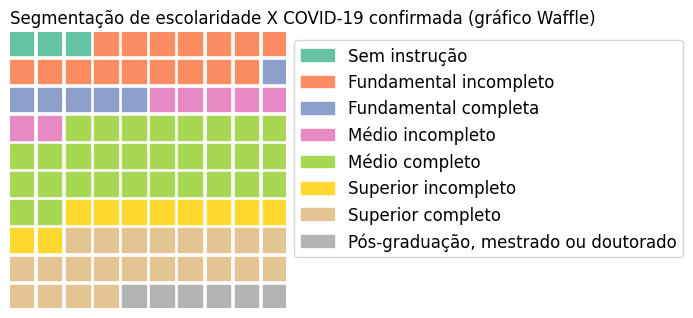

In [ ]:
# donut
fig = go.Figure()
fig.add_trace(
      go.Pie(
          labels=df_escolaridade_covid.nome,
          values=df_escolaridade_covid.contagem,
          hole=.65
      )
    )
fig.update_layout(title='Segmentação de escolaridade X COVID-19 confirmada')
fig.show()

# waffle
fig = plt.figure(
    FigureClass=Waffle,
    rows=10,
    columns=10,
    vertical=True,
    starting_location='NW',
    labels=df_escolaridade_covid.nome.tolist(),
    values=df_escolaridade_covid.contagem.tolist(),
    title={'label': 'Segmentação de escolaridade X COVID-19 confirmada (gráfico Waffle)', 'loc': 'left'},
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1), 'fontsize': 12},
    plot_anchor='C'
)
plt.show()

## 3.10) Plano de saúde + resultado positivo

In [ ]:
# preparando o dataframe segmentado
colunas = ['tem_plano_saude_b007', 'resultado_exame_b009b']

df_plano_saude_covid = df_pnad[df_pnad['resultado_exame_b009b'] == 1]
df_plano_saude_covid = df_plano_saude_covid[colunas].groupby('tem_plano_saude_b007').agg(contagem=('resultado_exame_b009b', 'count'))
df_plano_saude_covid = pd.merge(df_plano_saude_covid, df_resposta, left_on='tem_plano_saude_b007', right_on='id', how='inner')
df_plano_saude_covid.to_csv('segmentacao-plano-saude-x-casos-positivos.csv', index=False)
df_plano_saude_covid

,contagem,id,nome
0,6714,1,Sim
1,7722,2,Não
2,14,9,Ignorado


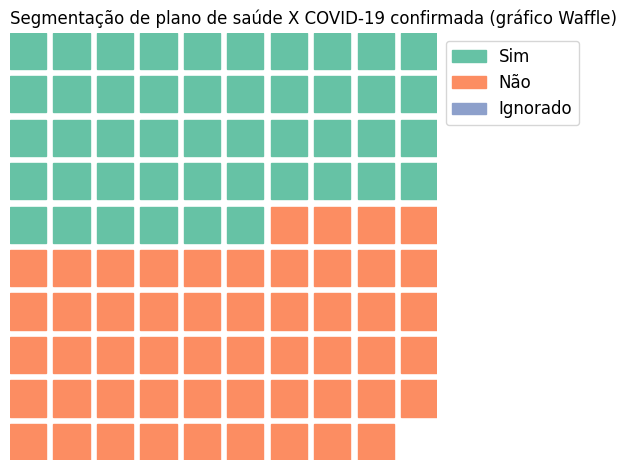

In [ ]:
# donut
fig = go.Figure()
fig.add_trace(
      go.Pie(
          labels=df_plano_saude_covid.nome,
          values=df_plano_saude_covid.contagem,
          hole=.65
      )
    )
fig.update_layout(title='Segmentação de plano de saúde X COVID-19 confirmada')
fig.show()

# waffle
fig = plt.figure(
    FigureClass=Waffle,
    rows=10,
    columns=10,
    vertical=True,
    starting_location='NW',
    labels=df_plano_saude_covid.nome.tolist(),
    values=df_plano_saude_covid.contagem.tolist(),
    title={'label': 'Segmentação de plano de saúde X COVID-19 confirmada (gráfico Waffle)', 'loc': 'left'},
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1), 'fontsize': 12},
    plot_anchor='C'
)

plt.show()

## 3.11) Infectados mês à mês
**COMENTÁRIO:** Neste bloco, é executado um job dentro do BigQuery. Este job foi previamente criado dentro da ferramenta e aqui estamos apenas reutilizando ele. Importante salientar que o job expira a cada 24H, necessitando mudar este ID.

In [ ]:
if ATIVAR_CONSULTA_VIA_JOBID_BIGQUERY:
  # aqui decidi executar a query dentro do próprio BigQuery
  # portanto, simplesmente rodo o job que guarda o histórico de execução da query
  # importante: vale notar que tabela temporária criada pelo job é reciclada após 24 horas
  # sendo necessário executar novamente a query original e gerar um novo job id (não parece ser muito prático)
  meses_map = {
      9: 'Setembro',
      10: 'Outubro',
      11: 'Novembro'
  }

  # roda o job do BigQuery e obtém os resultados
  query_job = client.get_job('bquxjob_9b6a278_18df318f73f')
  df_casos_positivos_mes_a_mes = query_job.result().to_dataframe()
  df_casos_positivos_mes_a_mes['mes_label'] = df_casos_positivos_mes_a_mes.mes.map(meses_map)
  df_casos_positivos_mes_a_mes.to_csv('evolucao-casos-positivos-mes-a-mes.csv', index=False)
  df_casos_positivos_mes_a_mes

  # plot da evolução dos últimos 3 meses
  fig = go.Figure(
      go.Bar(
        x=df_casos_positivos_mes_a_mes.mes_label,
        y=df_casos_positivos_mes_a_mes.total,
        name='Meses'
      )
  )

  fig.add_trace(
      go.Scatter(
          x=df_casos_positivos_mes_a_mes.mes_label,
          y=df_casos_positivos_mes_a_mes.total,
          mode='lines',
          name='Tendência'
      )
  )

  fig.update_layout(title='Evolução dos casos positivos nos últimos 3 meses',
                    xaxis_title='Mês',
                    yaxis_title='Número de casos positivos')

  fig.show()

## 3.12) Infectados por estado mês à mês
**COMENTÁRIO:** Neste bloco, é executado um job dentro do BigQuery. Este job foi previamente criado dentro da ferramenta e aqui estamos apenas reutilizando ele. Importante salientar que o job expira a cada 24H, necessitando mudar este ID.

In [ ]:
if ATIVAR_CONSULTA_VIA_JOBID_BIGQUERY:
  # roda o job do BigQuery e obtém os resultados
  query_job = client.get_job('bquxjob_1afdbba6_18df3194685')
  df_casos_positivos_mes_a_mes_por_uf = query_job.result().to_dataframe()
  df_casos_positivos_mes_a_mes_por_uf.to_csv('evolucao-casos-positivos-mes-a-mes-por-uf.csv', index=False)
  df_casos_positivos_mes_a_mes_por_uf

  # configs do gráfico
  num_colors = len(df_casos_positivos_mes_a_mes_por_uf['estado'].unique()) # quantidade de cores únicas
  colors = [f"hsl({h}, 50%, 50%)" for h in range(0, 320, int(320 / num_colors))] # cor final

  # plottando o gráfico
  fig = go.Figure()

  for i, state in enumerate(df_casos_positivos_mes_a_mes_por_uf['estado'].unique()):
      state_data = df_casos_positivos_mes_a_mes_por_uf[df_casos_positivos_mes_a_mes_por_uf['estado'] == state]
      fig.add_trace(go.Bar(x=state_data['mes'], y=state_data['total_casos_confirmados'], name=state, marker_color=colors[i]))

  fig.update_layout(title='Evolução dos casos positivos nos últimos 3 meses, agrupado por UF',
                    xaxis=dict(title='Mês'),
                    yaxis=dict(title='Total'),
                    barmode='group')

  fig.show()

## 3.13) Indicadores gerais

In [ ]:
total_registros = len(df_pnad)
total_registros_positivos = len(df_pnad[df_pnad['resultado_exame_b009b'] == 1])
total_registros_negativos = len(df_pnad[df_pnad['resultado_exame_b009b'] != 1])

total_registros_resultado_nao_ignorado = len(df_pnad[df_pnad['resultado_exame_b009b'] != 9])
total_registros_negativos_nao_ignorado = len(df_pnad[(df_pnad['resultado_exame_b009b'] != 1) & (df_pnad['resultado_exame_b009b'] != 9)])

df_indicadores_gerais = pd.DataFrame({
 'total_entrevistados': total_registros,
 'total_casos_positivos': total_registros_positivos,
 'porcentagem_total_casos_positivos': total_registros_positivos / total_registros * 100,
 'total_casos_negativos': total_registros_negativos,
 'porcentagem_total_casos_negativos': total_registros_negativos / total_registros * 100,
 'total_casos_positivos_nao_ignorados': total_registros_positivos,
 'porcentagem_total_casos_positivos_nao_ignorados': total_registros_positivos / total_registros_resultado_nao_ignorado * 100,
 'total_casos_negativos_nao_ignorados': total_registros_negativos_nao_ignorado,
 'porcentagem_total_casos_negativos_nao_ignorados': total_registros_negativos_nao_ignorado / total_registros_resultado_nao_ignorado * 100,
 'idade_media': df_pnad.morador_idade_a002.mean().round(2)
}, index=[0])
df_indicadores_gerais.to_csv('indicadores.csv', index=False)

In [ ]:
df_indicadores_gerais.head()

,total_entrevistados,total_casos_positivos,porcentagem_total_casos_positivos,total_casos_negativos,porcentagem_total_casos_negativos,total_casos_positivos_nao_ignorados,porcentagem_total_casos_positivos_nao_ignorados,total_casos_negativos_nao_ignorados,porcentagem_total_casos_negativos_nao_ignorados,idade_media
0,1149197,14450,1.2574,1134747,98.7426,14450,28.375619,36474,71.624381,36.98


# 4) Machine Learning
**COMENTÁRIO:** Nesta seção, são criados os modelos ensemble e unsupervised, utilizados pelo projeto.

## 4.1) Matriz de correlação dos dados

In [ ]:
colunas_renames_map = {
    'uf': 'Estado',
    'capital': 'Capital',
    'regiao_metropolitana': 'Região metropolitana',
    'semana_mes_v1012': 'Semana do mês',
    'mes_v1013': 'Mês',
    'situacao_domicilio_v1022': 'Situação do domícilio',
    'tipo_area_v1023': 'Tipo da área',
    'morador_idade_a002': 'Idade',
    'morador_sexo_a003': 'Sexo',
    'morador_raca_a004': 'Raça',
    'morador_escolaridade_a005': 'Escolaridade',
    'sintoma_febre_b0011': 'Sintoma: Febre',
    'sintoma_tosse_b0012': 'Sintoma:Tosse',
    'sintoma_dor_garganta_b0013': 'Sintoma:Dor de garganta',
    'sintoma_dificuldade_respiracao_b0014': 'Sintoma:Difilcudade de respiração',
    'sintoma_dor_cabeca_b0015': 'Sintoma:Dor de cabeça',
    'sintoma_dor_peito_b0016': 'Sintoma:Dor no peito',
    'sintoma_nausea_b0017': 'Sintoma:Náusea',
    'sintoma_nariz_entupido_b0018': 'Sintoma:Nariz entupido',
    'sintoma_fadiga_b0019': 'Sintoma:Fadiga',
    'sintoma_dor_olhos_b00110': 'Sintoma:Dor nos olhos',
    'sintoma_perda_olfato_b00111': 'Sintoma:Perda de olfato',
    'sintoma_dor_muscular_b00112': 'Sintoma:Dor muscular',
    'sintoma_diarreia_b00113': 'Sintoma:Diárreia',
    'compareceu_estabelecimento_saude_b002': 'Compareceu estabelecimento',
    'sedado_entubado_b006': 'Foi sedado/entubado',
    'tem_plano_saude_b007': 'Plano de saúde',
    'resultado_exame_b009b': 'Resulado do exame',
    'medida_restricao_contato_b011': 'Medida de restrição',
    'trabalhou_remoto_c013': 'Trabalhou remotamente',
    'recebeu_auxilio_emergencial_d0051': 'Recebeu auxílio'
}

matriz_correlacao = df_pnad.rename(columns=colunas_renames_map).corr()
matriz_correlacao.to_csv('correlacao-ensemble.csv', index=False)
matriz_correlacao

,Estado,Capital,Região metropolitana,Semana do mês,Mês,Situação do domícilio,Tipo da área,Idade,Sexo,Raça,...,Sintoma:Perda de olfato,Sintoma:Dor muscular,Sintoma:Diárreia,Compareceu estabelecimento,Foi sedado/entubado,Plano de saúde,Resulado do exame,Medida de restrição,Trabalhou remotamente,Recebeu auxílio
Estado,1.000000,1.000000,0.999973,-0.003434,0.000068,-0.096999,0.010940,0.075270,0.001069,-0.266116,...,-0.002213,-0.003438,-0.001586,-0.004042,-0.004413,-0.131018,-0.072154,0.001808,-0.029142,0.188540
Capital,1.000000,1.000000,1.000000,0.001370,-0.000066,0.040197,NaN,0.077778,0.001835,-0.217426,...,-0.005429,-0.006489,-0.005065,-0.009768,-0.003827,-0.124845,-0.104790,0.025717,-0.061718,0.152745
Região metropolitana,0.999973,1.000000,1.000000,-0.001828,0.001288,-0.052147,0.054983,0.064419,-0.003962,-0.252005,...,-0.006312,-0.008249,-0.005673,-0.009617,-0.005626,-0.107201,-0.095397,0.014996,-0.051159,0.148751
Semana do mês,-0.003434,0.001370,-0.001828,1.000000,-0.003796,-0.001212,-0.002909,0.003774,0.000169,0.001253,...,-0.005741,-0.005501,-0.005494,0.001499,0.000863,-0.002609,-0.006379,-0.014740,0.002314,-0.000789
Mês,0.000068,-0.000066,0.001288,-0.003796,1.000000,-0.003053,-0.005087,0.003910,0.000675,-0.000290,...,-0.006284,-0.005843,-0.006271,0.013240,0.000005,-0.009530,-0.032126,-0.077593,0.006135,0.025904
Situação do domícilio,-0.096999,0.040197,-0.052147,-0.001212,-0.003053,1.000000,0.345788,-0.019772,-0.034067,0.073349,...,-0.012170,-0.012045,-0.012768,0.012243,0.004350,0.149118,0.074730,0.044070,0.066634,-0.127359
Tipo da área,0.010940,NaN,0.054983,-0.002909,-0.005087,0.345788,1.000000,-0.016657,-0.019897,-0.000682,...,-0.019374,-0.019513,-0.020146,0.014887,0.003508,0.141320,0.093759,0.001985,0.082887,-0.068234
Idade,0.075270,0.077778,0.064419,0.003774,0.003910,-0.019772,-0.016657,1.000000,0.048482,-0.079444,...,-0.007140,-0.015287,-0.005904,-0.035546,-0.017463,-0.050914,-0.035755,-0.057867,-0.043094,0.207607
Sexo,0.001069,0.001835,-0.003962,0.000169,0.000675,-0.034067,-0.019897,0.048482,1.000000,-0.013371,...,-0.001014,-0.002734,-0.000684,-0.024222,0.000032,-0.014539,-0.010084,0.085277,0.008945,0.009043
Raça,-0.266116,-0.217426,-0.252005,0.001253,-0.000290,0.073349,-0.000682,-0.079444,-0.013371,1.000000,...,0.004605,0.004191,0.004806,0.000097,0.001502,0.145641,0.034386,-0.003592,0.048984,-0.172679


In [ ]:
# plot do heatmap (correlação)
fig = go.Figure(data=go.Heatmap(z=matriz_correlacao.values[::-1],
                                 x=matriz_correlacao.columns,
                                 y=matriz_correlacao.columns[::-1],
                                 colorbar=dict(title='Correlação'),
                                 colorscale='Viridis',
                                 xgap=1,
                                 ygap=1))

fig.update_layout(title='Matriz de correlação', height=1200)
fig.update_layout(xaxis_side="top", xaxis=dict(tickangle=-45))
fig.show()

## 4.2) Criando um modelo de previsão para identificar se um entrevistado está com COVID-19 ou não, utilizando o algoritmo de Ensemble XGBoost

### 4.2.1) XGBoost
**COMENTÁRIO:** O intuíto principal deste modelo é prever se uma pessoa está ou não infectada. No caso, são criados dois modelos do XGBoost, um utilizando parâmetros padrão (default) e outro onde sugerimos os parâmetros.

#### 4.2.1.1) Feature Engineering

In [ ]:
df_pnad.columns

Index(['uf', 'capital', 'regiao_metropolitana', 'semana_mes_v1012',
       'mes_v1013', 'situacao_domicilio_v1022', 'tipo_area_v1023',
       'morador_idade_a002', 'morador_sexo_a003', 'morador_raca_a004',
       'morador_escolaridade_a005', 'sintoma_febre_b0011',
       'sintoma_tosse_b0012', 'sintoma_dor_garganta_b0013',
       'sintoma_dificuldade_respiracao_b0014', 'sintoma_dor_cabeca_b0015',
       'sintoma_dor_peito_b0016', 'sintoma_nausea_b0017',
       'sintoma_nariz_entupido_b0018', 'sintoma_fadiga_b0019',
       'sintoma_dor_olhos_b00110', 'sintoma_perda_olfato_b00111',
       'sintoma_dor_muscular_b00112', 'sintoma_diarreia_b00113',
       'compareceu_estabelecimento_saude_b002', 'sedado_entubado_b006',
       'tem_plano_saude_b007', 'resultado_exame_b009b',
       'medida_restricao_contato_b011', 'trabalhou_remoto_c013',
       'recebeu_auxilio_emergencial_d0051'],
      dtype='object')

In [ ]:
pnad_feature_columns = ['sintoma_febre_b0011',
       'sintoma_tosse_b0012', 'sintoma_dor_garganta_b0013',
       'sintoma_dificuldade_respiracao_b0014', 'sintoma_dor_cabeca_b0015',
       'sintoma_dor_peito_b0016', 'sintoma_nausea_b0017',
       'sintoma_nariz_entupido_b0018', 'sintoma_fadiga_b0019',
       'sintoma_dor_olhos_b00110', 'sintoma_perda_olfato_b00111',
       'sintoma_dor_muscular_b00112', 'sintoma_diarreia_b00113']

pnad_target_column = ['resultado_exame_b009b']

In [ ]:
df_ml = df_pnad.copy()

# preenche valores <NA> com 0
df_ml.fillna(0, inplace=True)

# dropa linhas que possuem resultado_exame = 9 (ignorado)
df_ml['resultado_exame_b009b'] = df_ml['resultado_exame_b009b'].astype(int)
df_ml = df_ml.query('resultado_exame_b009b != 9')

# obtém uma amostra de 10000 registros
# aqui o parâmetro de weights é importante para gerar um sample estratificado que possua todas as categorias de classificaçao
df_ml = df_ml.sample(n=10000, random_state=777, weights=pnad_target_column[0])

# divide as colunas da amostra em X (features) e Y (target)
x = df_ml[pnad_feature_columns]
y = df_ml[pnad_target_column]

In [ ]:
segmentacao_por_resultado = df_ml.groupby(by='resultado_exame_b009b').size() # cria uma series com as contagens por categoria de resultado
segmentacao_por_resultado = segmentacao_por_resultado.to_frame().reset_index() # transforma num dataframe
segmentacao_por_resultado.rename(columns={segmentacao_por_resultado.columns[1]: 'total'}, inplace=True) # renomeia a coluna de contagem
segmentacao_por_resultado = pd.merge(segmentacao_por_resultado, df_resultado_exame, left_on='resultado_exame_b009b', right_on='id', how='inner')
segmentacao_por_resultado

,resultado_exame_b009b,total,id,nome
0,1,1719,1,Positivo
1,2,7690,2,Negativo
2,3,84,3,Inconclusivo
3,4,507,4,Ainda não recebeu o resultado


In [ ]:
# faz o split da amostra, durante os testes, o stratify em certos momentos não funcionava, pois não haviam mais de 1 classe de classificação no sample gerado anteriormente
# isso demonstra a importância do parâmetro weigth utilizado para sample na etapa anterior
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=777)

In [ ]:
print(f'shape x_train: {x_train.shape}')
print(f'shape x_test: {x_test.shape}')
print(f'shape y_train: {y_train.shape}')
print(f'shape y_test: {y_test.shape}')

shape x_train: (8000, 13)
shape x_test: (2000, 13)
shape y_train: (8000, 1)
shape y_test: (2000, 1)


In [ ]:
x_train.head()

,sintoma_febre_b0011,sintoma_tosse_b0012,sintoma_dor_garganta_b0013,sintoma_dificuldade_respiracao_b0014,sintoma_dor_cabeca_b0015,sintoma_dor_peito_b0016,sintoma_nausea_b0017,sintoma_nariz_entupido_b0018,sintoma_fadiga_b0019,sintoma_dor_olhos_b00110,sintoma_perda_olfato_b00111,sintoma_dor_muscular_b00112,sintoma_diarreia_b00113
346735,2,2,2,2,2,2,2,2,2,2,2,2,2
343274,2,2,2,2,2,2,2,2,2,2,2,2,2
151094,2,2,2,2,2,2,2,2,2,2,2,2,2
796941,2,2,2,2,2,2,2,2,2,2,2,2,2
846317,2,2,2,2,2,2,2,2,2,2,2,2,2


In [ ]:
y_train.rename(columns={'resultado_exame_b009b': 'y'}, inplace=True)

In [ ]:
y_train.head()

,y
346735,2
343274,2
151094,2
796941,2
846317,2


In [ ]:
y_train.y.value_counts()

2    6152
1    1375
4     406
3      67
Name: y, dtype: int64

In [ ]:
y_train['y'].ravel()

array([2, 2, 2, ..., 2, 2, 2])

#### 4.2.1.2) Obtendo os melhores parâmetros do XGBoost

In [ ]:
def melhores_hiperparamentros_xgb(x_train, y_train):
    param_grid = {
      'learning_rate':[0.01, 0.05, 0.2],
      'n_estimators':[50, 100, 200],
      'max_depth': [1, 2, 5, 8]
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid = GridSearchCV(
      GradientBoostingClassifier(),
      param_grid = param_grid,
      scoring = 'f1',
      cv = cv,
      n_jobs= -1
    )

    # seleciona os melhores hiperparâmetros com base nos dados de treino
    grid.fit(x_train, y_train)
    xgb_params = grid.best_params_

    print("Melhores hiperparâmetros para XGB:", xgb_params)

    return xgb_params

In [ ]:
# DESATIVADO PELO TEMPO DEMANDADO PARA EXECUÇÃO
# params = melhores_hiperparamentros_xgb(x_train, y_train)
# params

# apesar dos pesares, max_depth = 1, não aparenta ser um bom parâmetro!
# Melhores hiperparâmetros para XGB: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 50}

#### 4.2.1.3) Execução do XGB com hiperparâmetros default

In [ ]:
kfold = KFold(n_splits=30, shuffle=True)
xgb1 = GradientBoostingClassifier()
xgb1.fit(x_train, y_train)
xgb1_result = cross_val_score(xgb1, x_train, y_train, cv = kfold)

In [ ]:
# verificando o score
xgb1_result.mean()

0.7724972543718848

In [ ]:
# fazendo as previsçoes e verificando a acurácia
xgb1_previsoes = xgb1.predict(x_test)
xgb1_acuracia = accuracy_score(y_true = y_test, y_pred = xgb1_previsoes) * 100
xgb1_acuracia

77.2

In [ ]:
xgb1.predict(x_test[:20])

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

#### 4.2.1.4) Execução do XGB com hiperparâmetros sugeridos

In [ ]:
kfold = KFold(n_splits=40, shuffle=True)
xgb2 = GradientBoostingClassifier(learning_rate=0.075, max_depth=8, n_estimators=50)
xgb2.fit(x_train, y_train)
xgb2_result = cross_val_score(xgb2, x_train, y_train, cv = kfold)

In [ ]:
xgb2_result.mean()

0.771625

In [ ]:
xgb2_previsoes = xgb2.predict(x_test)
xgb2_acuracia = accuracy_score(y_true = y_test, y_pred = xgb2_previsoes) * 100
xgb2_acuracia

76.9

In [ ]:
print(f'XGB1 (parâmetros default) = {xgb1_acuracia:.2f}% VS XGB2 (parâmetros sugeridos) = {xgb2_acuracia:.2f}%')

XGB1 (parâmetros default) = 77.20% VS XGB2 (parâmetros sugeridos) = 76.90%


In [ ]:
def teste_resultados_xgb(modelo):
  metrica = modelo.predict(x_train)
  print(f'Quantidade com id 1 (SIM) - base de treino: {np.sum(metrica == 1)}')
  metrica = modelo.predict(x_test)
  print(f'Quantidade com id 1 (SIM) - base de teste: {np.sum(metrica == 1)}')

  metrica = modelo.predict(x_train)
  print(f'Quantidade com id 2 (NÃO) - base de treino: {np.sum(metrica == 2)}')
  metrica = modelo.predict(x_test)
  print(f'Quantidade com id 2 (NÃO) - base de teste: {np.sum(metrica == 2)}')

In [ ]:
teste_resultados_xgb(xgb1)
teste_resultados_xgb(xgb2)

Quantidade com id 1 (SIM) - base de treino: 158
Quantidade com id 1 (SIM) - base de teste: 44
Quantidade com id 2 (NÃO) - base de treino: 7715
Quantidade com id 2 (NÃO) - base de teste: 1923
Quantidade com id 1 (SIM) - base de treino: 170
Quantidade com id 1 (SIM) - base de teste: 52
Quantidade com id 2 (NÃO) - base de treino: 7655
Quantidade com id 2 (NÃO) - base de teste: 1911


#### 4.2.1.5) Exportando os modelos via joblib para uso posterior

In [ ]:
joblib.dump(xgb1, 'xgb-default.pkl')
joblib.dump(xgb2, 'xgb-sugeridos.pkl')

['xgb-sugeridos.pkl']

In [ ]:
# importante salvar sem o index dos dfs
x_test.to_csv('xgb_x_test.csv', index=False)
y_test.to_csv('xgb_y_test.csv', index=False)

#### 4.2.1.6) Testando a exportação dos modelos

In [ ]:
def recarrega_modelo_xgb(file: str):
  xgb_recarregado = joblib.load(file)
  xgb_recarregado_previsoes = xgb_recarregado.predict(x_test)
  xgb_recarregado_acuracia = accuracy_score(y_true = y_test, y_pred = xgb_recarregado_previsoes) * 100

  print(f'{xgb_recarregado_acuracia:.2f}%')

In [ ]:
recarrega_modelo_xgb('xgb-default.pkl')

77.20%


In [ ]:
recarrega_modelo_xgb('xgb-sugeridos.pkl')

76.90%


## 4.3) Criando um modelo de clusterização para identificar como os entrevistados estão agrupados entre si, utilizando KMeans

### 4.3.1) KMeans
**COMENTÁRIO:** A ideia aqui é relacionar e segmentar usuários, conforme a gravidade dos sintomas apresentados (gravidade a qual foi elencada por mim, para fins de teste, sem muita base médica para tal), a quantidade de sintomas apresentados de cada gravidade, se o entrevistado possui plano de saúde, se ele fez homeoffice, se teve COVID-19 confirmada e por fim, se foi ou não entubado. Desta maneira, espero conseguir criar grupos bem definidos, os quais permitam classificarmos o resto da base de entrevistados.

#### 4.3.1.1) Preparando o dataframe que será utilizado no treinamento do modelo

In [ ]:
def prepara_df_kmeans(df: pd.DataFrame) -> pd.DataFrame:
  sintomas_leves = [
    'sintoma_dor_garganta_b0013',
    'sintoma_dor_cabeca_b0015',
    'sintoma_nausea_b0017',
    'sintoma_nariz_entupido_b0018',
    'sintoma_fadiga_b0019',
    'sintoma_dor_olhos_b00110',
    'sintoma_perda_olfato_b00111',
    'sintoma_diarreia_b00113'
  ]
  sintomas_medios = ['sintoma_febre_b0011', 'sintoma_tosse_b0012', 'sintoma_dor_muscular_b00112']
  sintomas_graves = ['sintoma_dificuldade_respiracao_b0014', 'sintoma_dor_peito_b0016']
  todos_sintomas = sintomas_leves + sintomas_medios + sintomas_graves
  colunas = [
      'homeoffice',
      'tem_plano',
      'entubado',
      'resultado_exame',
      'tem_sintomas_leves',
      'tem_sintomas_medios',
      'tem_sintomas_graves',
      'total_sintomas_leves',
      'total_sintomas_medios',
      'total_sintomas_graves',
      'total_sintomas',
    ]

  df_kmeans = pd.DataFrame(columns=colunas)
  df_kmeans['homeoffice'] = df['trabalhou_remoto_c013']
  df_kmeans['tem_plano'] = df['tem_plano_saude_b007']
  df_kmeans['entubado'] = df['sedado_entubado_b006']
  df_kmeans['resultado_exame'] = df['resultado_exame_b009b']
  df_kmeans['tem_sintomas_leves'] = df[sintomas_leves].eq(1).any(axis=1).astype(int)
  df_kmeans['tem_sintomas_medios'] = df[sintomas_medios].eq(1).any(axis=1).astype(int)
  df_kmeans['tem_sintomas_graves'] = df[sintomas_graves].eq(1).any(axis=1).astype(int)
  df_kmeans['total_sintomas_leves'] = df[sintomas_leves].eq(1).sum(axis=1)
  df_kmeans['total_sintomas_medios'] = df[sintomas_medios].eq(1).sum(axis=1)
  df_kmeans['total_sintomas_graves'] = df[sintomas_graves].eq(1).sum(axis=1)
  df_kmeans['total_sintomas'] = df[todos_sintomas].eq(1).sum(axis=1)

  return df_kmeans

In [ ]:
df_ml = df_pnad.sample(n=100000, random_state=777)
df_kmeans = prepara_df_kmeans(df_ml)

In [ ]:
df_kmeans.isnull().sum()

homeoffice               0
tem_plano                0
entubado                 0
resultado_exame          0
tem_sintomas_leves       0
tem_sintomas_medios      0
tem_sintomas_graves      0
total_sintomas_leves     0
total_sintomas_medios    0
total_sintomas_graves    0
total_sintomas           0
dtype: int64

In [ ]:
df_kmeans.head()

,homeoffice,tem_plano,entubado,resultado_exame,tem_sintomas_leves,tem_sintomas_medios,tem_sintomas_graves,total_sintomas_leves,total_sintomas_medios,total_sintomas_graves,total_sintomas
1054424,9,2,9,9,0,0,0,0.0,0.0,0.0,0.0
1030830,9,2,9,9,0,0,0,0.0,0.0,0.0,0.0
1057347,1,2,9,9,0,0,0,0.0,0.0,0.0,0.0
408391,9,1,9,9,0,0,0,0.0,0.0,0.0,0.0
116326,9,2,9,9,1,0,0,1.0,0.0,0.0,1.0


In [ ]:
df_kmeans.shape

(100000, 11)

In [ ]:
X = df_kmeans.copy()
X.head()

,homeoffice,tem_plano,entubado,resultado_exame,tem_sintomas_leves,tem_sintomas_medios,tem_sintomas_graves,total_sintomas_leves,total_sintomas_medios,total_sintomas_graves,total_sintomas
1054424,9,2,9,9,0,0,0,0.0,0.0,0.0,0.0
1030830,9,2,9,9,0,0,0,0.0,0.0,0.0,0.0
1057347,1,2,9,9,0,0,0,0.0,0.0,0.0,0.0
408391,9,1,9,9,0,0,0,0.0,0.0,0.0,0.0
116326,9,2,9,9,1,0,0,1.0,0.0,0.0,1.0


#### 4.3.1.2) Verificando a matriz de correlação das colunas do dataframe

In [ ]:
matriz_correlacao_unsupervised = X.corr()

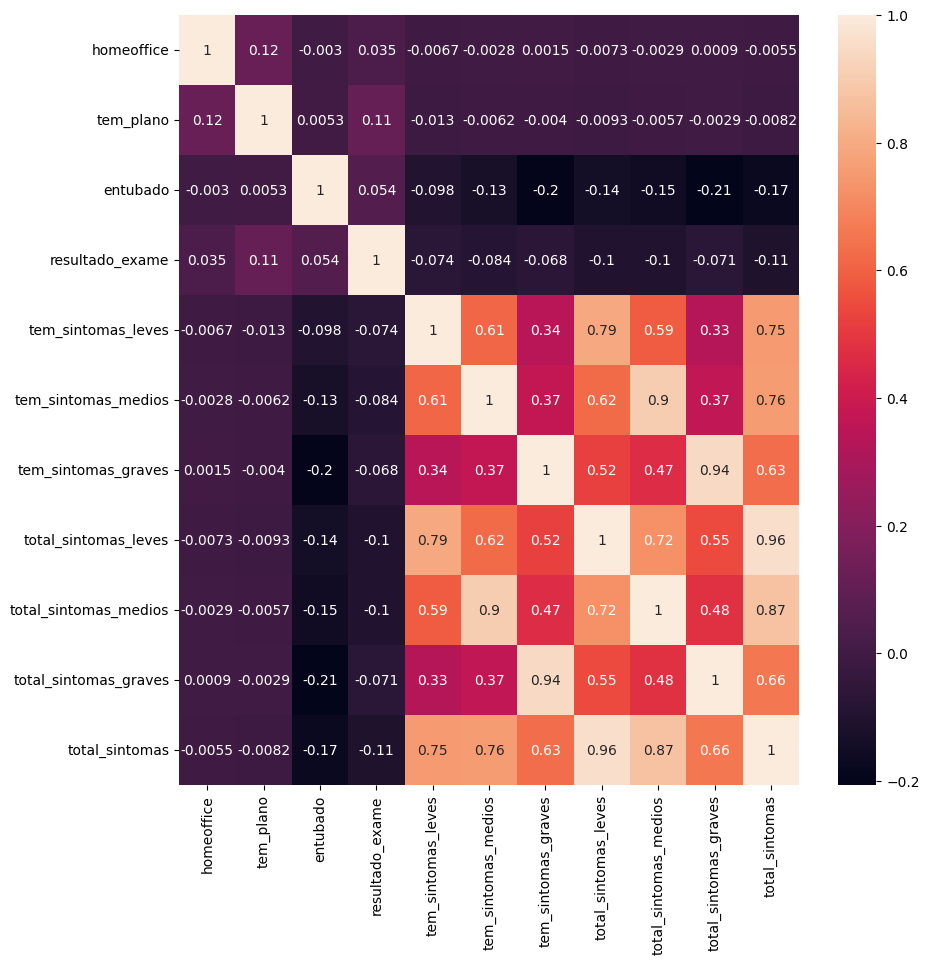

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(data=matriz_correlacao_unsupervised, annot=True)
plt.show()

In [ ]:
colunas_renames_map_unsupervised = {
    'homeoffice': 'Fez homeoffice',
    'tem_plano': 'Plano de saúde',
    'entubado': 'Foi entubado/sedado',
    'resultado_exame': "Resultado do exame COVID-19",
    'tem_sintomas_leves': 'Possui sintomas leves',
    'tem_sintomas_medios': 'Possui sintomas médios',
    'tem_sintomas_graves': 'Possui sintomas graves',
    'total_sintomas_leves': 'Total de sintomas leves',
    'total_sintomas_medios': 'Total de sintomas médios',
    'total_sintomas_graves': 'Total de sintomas graves',
    'total_sintomas': 'Total de sintomas geral'
}

matriz_correlacao_unsupervised = matriz_correlacao_unsupervised.rename(columns=colunas_renames_map_unsupervised).corr()
matriz_correlacao_unsupervised.to_csv('correlacao-unsupervised.csv', index=False)
matriz_correlacao_unsupervised

,Fez homeoffice,Plano de saúde,Foi entubado/sedado,Resultado do exame COVID-19,Possui sintomas leves,Possui sintomas médios,Possui sintomas graves,Total de sintomas leves,Total de sintomas médios,Total de sintomas graves,Total de sintomas geral
Fez homeoffice,1.000000,0.127388,0.002724,0.024324,-0.393676,-0.386404,-0.348383,-0.410983,-0.396757,-0.348323,-0.418173
Plano de saúde,0.127388,1.000000,0.026323,0.175774,-0.438612,-0.428272,-0.390173,-0.454530,-0.439913,-0.388838,-0.463322
Foi entubado/sedado,0.002724,0.026323,1.000000,0.184788,-0.542428,-0.573148,-0.660323,-0.616934,-0.611868,-0.665345,-0.652036
Resultado do exame COVID-19,0.024324,0.175774,0.184788,1.000000,-0.557152,-0.565950,-0.505524,-0.600885,-0.592792,-0.508840,-0.615385
Possui sintomas leves,-0.393676,-0.438612,-0.542428,-0.557152,1.000000,0.866244,0.554868,0.950551,0.869567,0.562534,0.919243
Possui sintomas médios,-0.386404,-0.428272,-0.573148,-0.565950,0.866244,1.000000,0.574249,0.882236,0.986290,0.581012,0.918152
Possui sintomas graves,-0.348383,-0.390173,-0.660323,-0.505524,0.554868,0.574249,1.000000,0.717037,0.662189,0.997470,0.772333
Total de sintomas leves,-0.410983,-0.454530,-0.616934,-0.600885,0.950551,0.882236,0.717037,1.000000,0.923338,0.730037,0.988336
Total de sintomas médios,-0.396757,-0.439913,-0.611868,-0.592792,0.869567,0.986290,0.662189,0.923338,1.000000,0.672064,0.959249
Total de sintomas graves,-0.348323,-0.388838,-0.665345,-0.508840,0.562534,0.581012,0.997470,0.730037,0.672064,1.000000,0.783569


In [ ]:
# plot do heatmap (correlação) via Plotly para uso no Streamlit
fig = go.Figure(data=go.Heatmap(z=matriz_correlacao_unsupervised.values[::-1],
                                 x=matriz_correlacao_unsupervised.columns,
                                 y=matriz_correlacao_unsupervised.columns[::-1],
                                 colorbar=dict(title='Correlação'),
                                 colorscale='Viridis',
                                 xgap=1,
                                 ygap=1))

fig.update_layout(title='Matriz de correlação', height=700, width=800)
fig.update_layout(xaxis_side="top", xaxis=dict(tickangle=-45))
fig.show()

In [ ]:
print(X.total_sintomas_graves.value_counts())
print(X.total_sintomas_medios.value_counts())
print(X.total_sintomas_leves.value_counts())

0.0    99445
1.0      383
2.0      172
Name: total_sintomas_graves, dtype: int64
0.0    97777
1.0     1517
2.0      484
3.0      222
Name: total_sintomas_medios, dtype: int64
0.0    96629
1.0     1917
2.0      762
3.0      299
4.0      173
5.0       88
6.0       49
7.0       46
8.0       37
Name: total_sintomas_leves, dtype: int64


#### 4.3.1.3) Escalonando e reduzindo a dimensionalidade dos dados para treino

In [ ]:
# devido à grande quantidade de variáveis, utilizo o PCA para reduzir o número de features finais em 2
def apply_scaler_and_pca(X: pd.DataFrame) -> pd.DataFrame:
  scaler = StandardScaler()
  pca = PCA(n_components=2)

  X_escalonado = scaler.fit_transform(X)
  X_pca = pca.fit_transform(X_escalonado)

  print('PCA variância', pca.explained_variance_ratio_)

  return (X_pca, scaler, pca)

In [ ]:
X_pca, scaler, pca = apply_scaler_and_pca(X)

PCA variância [0.44447957 0.11438484]


#### 4.3.1.4) Método Elbow + métricas de clusterização para identificar o K centroídes ideal

In [ ]:
def plot_kmeans_elbow(X: pd.DataFrame):
  df_elbow = pd.DataFrame(columns=['k', 'sse', 'silhouete_score', 'davies_bouldin_score', 'calinski_harabasz_score'])
  k_elbows = range(2, 10)

  # roda o K-means para cada k fornecido
  for total_clusters in k_elbows:
      kmeans = KMeans(n_clusters=total_clusters, random_state=777)
      kmeans.fit(X)

      score_s = silhouette_score(X, kmeans.labels_) # valor mais alto = melhor
      score_db = davies_bouldin_score(X, kmeans.labels_) # valor mais baixo = melhor
      score_ch = calinski_harabasz_score(X, kmeans.labels_) # valor mais alto = melhor

      # adiciona o item processado no df
      df_elbow = pd.concat([
          df_elbow,
          pd.DataFrame({
            'k': [total_clusters],
            'sse': [kmeans.inertia_],
            'silhouete_score': [score_s],
            'davies_bouldin_score': [score_db],
            'calinski_harabasz_score': [score_ch]
          })
      ], ignore_index=True)

      print(f'clusters={total_clusters} | silhouete score={score_s:.5f} | davies bouldin score={score_db} | calinski={score_ch}')

  # exporta o resultado do elbow
  df_elbow.to_csv('elbow.csv')

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=df_elbow['k'], y=df_elbow['sse'], mode='lines+markers'))
  fig.update_traces(
      marker=dict(
          size=14,
          color='red'
      ),
      name='ronaldo',
      selector=dict(mode='lines+markers')
  )
  fig.update_layout(
      title='Gráfico de Elbow',
      xaxis_title='Número de clusters',
      yaxis_title='Inércia',
      width=700
  )
  fig.show()

In [ ]:
# DESATIVADO DEVIDO AO ALTO CUSTO DE PROCESSAMENTO
# plot_kmeans_elbow(X_pca)

# -- OUTPUT com 100.000 registros
# clusters=2 | silhouete score=0.97033 | davies bouldin score=0.6363259872249748 | calinski=141347.6917070878
# clusters=3 | silhouete score=0.97063 | davies bouldin score=0.5173408128894142 | calinski=243984.85585159852
# clusters=4 | silhouete score=0.98134 | davies bouldin score=0.48474459222963906 | calinski=281941.14104787825
# clusters=5 | silhouete score=0.98168 | davies bouldin score=0.5479835187931573 | calinski=390902.16561598907 <<<<
# clusters=6 | silhouete score=0.98250 | davies bouldin score=0.56051725227559 | calinski=416446.2118575983
# clusters=7 | silhouete score=0.98247 | davies bouldin score=0.5852375602500868 | calinski=480265.7427396488
# clusters=8 | silhouete score=0.98266 | davies bouldin score=0.5570696505421153 | calinski=511296.53709895466
# clusters=9 | silhouete score=0.98260 | davies bouldin score=0.5902502354061119 | calinski=535823.9246535943

# -- OUTPUT com 1.000 registros
# clusters=2 | silhouete score=0.95018 | davies bouldin score=0.6344521664398327 | calinski=1355.973598428093
# clusters=3 | silhouete score=0.94050 | davies bouldin score=0.3816390571583792 | calinski=2996.3318662944253
# clusters=4 | silhouete score=0.92180 | davies bouldin score=0.41323588531759065 | calinski=3219.1100425626787
# clusters=5 | silhouete score=0.92167 | davies bouldin score=0.32625772014924004 | calinski=3649.0217274289894 <<<<
# clusters=6 | silhouete score=0.88918 | davies bouldin score=0.35639828201397666 | calinski=5181.379324160767
# clusters=7 | silhouete score=0.89020 | davies bouldin score=0.35628083711543695 | calinski=6408.013864932
# clusters=8 | silhouete score=0.94106 | davies bouldin score=0.3096369927682969 | calinski=8585.496505637975
# clusters=9 | silhouete score=0.94742 | davies bouldin score=0.2957716603369056 | calinski=10071.788671351198

clusters=2 | silhouete score=0.96656 | davies bouldin score=0.6411286991377148 | calinski=141896.57116285604
clusters=3 | silhouete score=0.96538 | davies bouldin score=0.5174114438940579 | calinski=240397.72255190698
clusters=4 | silhouete score=0.97139 | davies bouldin score=0.4861013556231547 | calinski=273373.63153981924
clusters=5 | silhouete score=0.97160 | davies bouldin score=0.5774453953506868 | calinski=354639.11118159007
clusters=6 | silhouete score=0.97237 | davies bouldin score=0.5800783368004911 | calinski=372051.6968141017
clusters=7 | silhouete score=0.97249 | davies bouldin score=0.5883631606022005 | calinski=430073.3911581555
clusters=8 | silhouete score=0.97268 | davies bouldin score=0.5759540735613193 | calinski=471089.73616263503
clusters=9 | silhouete score=0.97218 | davies bouldin score=0.5580785294088008 | calinski=472938.67272001615


**COMENTÁRIO:** Segundo o método Elbow e utilizando os scores *Silhouette*, *Davies Bouldin* e *Calinski Harabasz*, podemos definir a quantidade de 5 centroides para o KMeans

#### 4.1.3.5) Execução do modelo KMeans

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=777)
y_kmeans = kmeans.fit_predict(X_pca)
centroides = kmeans.cluster_centers_

In [ ]:
# verificando a quantidade de registros por grupo (centróide)
pd.DataFrame(y_kmeans).value_counts()

0    96049
1     2060
3     1314
2      324
4      253
dtype: int64

In [ ]:
# os centróides e suas posições
centroides

array([[-0.35116318,  0.07829518],
       [ 3.89699569, -2.43777094],
       [15.04039339, 10.27874843],
       [10.36541376, -6.0069942 ],
       [28.48940771,  8.16011906]])

#### 4.3.1.6) Plot do modelo KMeans e seus centroídes

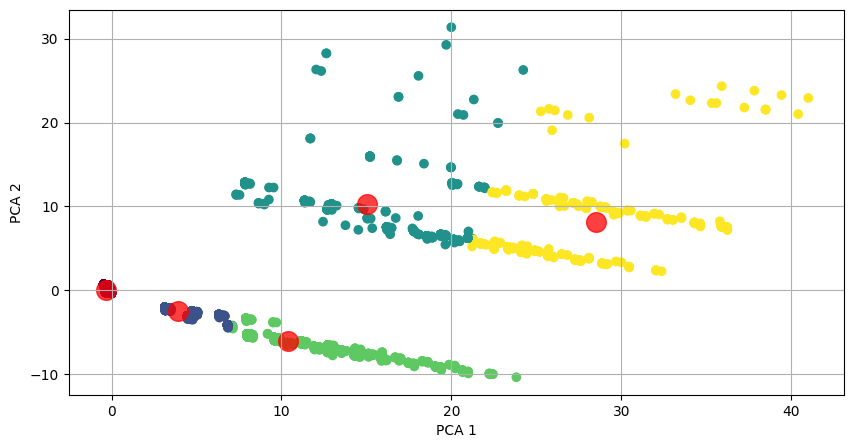

In [ ]:
plt.figure(figsize=(10, 5))

# plotando os dados e identificando os seus clusters
plt.scatter(x=X_pca[:, 0], y=X_pca[:, 1], c=y_kmeans, cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

# plotando os centróides
plt.scatter(centroides[:, 0], centroides[:, 1], c='red', marker='o', s=200, alpha=0.75)

plt.grid()
plt.show()

#### 4.3.1.7) Testando o modelo criado com outros registros aleatórios do dataframe original

In [ ]:
# testando o modelo e prevendo os grupos (centroides) de cada registro
df_teste_ml = df_pnad.sample(n=1000, random_state=444) # pega 1000 registros aleatórios
df_teste_kmeans = prepara_df_kmeans(df_teste_ml)
X_teste, scaler, pca = apply_scaler_and_pca(df_teste_kmeans)

teste_pred = kmeans.predict(X_teste)
teste_pred.shape

PCA variância [0.43382124 0.14223447]


(1000,)

In [ ]:
pd.DataFrame(teste_pred).value_counts()

0    968
1     14
3     14
2      3
4      1
dtype: int64

In [ ]:
df_teste_ml['centroide'] = np.array(teste_pred)
df_teste_ml.head(20)

,uf,capital,regiao_metropolitana,semana_mes_v1012,mes_v1013,situacao_domicilio_v1022,tipo_area_v1023,morador_idade_a002,morador_sexo_a003,morador_raca_a004,...,sintoma_dor_muscular_b00112,sintoma_diarreia_b00113,compareceu_estabelecimento_saude_b002,sedado_entubado_b006,tem_plano_saude_b007,resultado_exame_b009b,medida_restricao_contato_b011,trabalhou_remoto_c013,recebeu_auxilio_emergencial_d0051,centroide
472891,52,<NA>,52,3,11,1,2,12,2,4,...,2,2,9,9,1,9,2,9,2,0
385817,35,<NA>,<NA>,2,11,2,4,20,1,4,...,2,2,2,9,2,9,2,9,1,1
521406,23,<NA>,<NA>,2,9,1,4,35,1,1,...,2,2,9,9,2,9,3,9,2,0
211260,15,<NA>,15,3,9,1,2,5,1,1,...,2,2,9,9,1,9,4,9,2,0
161983,42,<NA>,42,3,11,1,2,56,2,1,...,2,2,9,9,1,9,3,1,2,0
665258,51,<NA>,<NA>,1,9,1,4,6,2,4,...,2,2,9,9,2,9,3,9,2,0
566152,23,<NA>,<NA>,3,10,2,4,17,1,4,...,2,2,9,9,2,9,3,9,2,0
293777,43,<NA>,<NA>,2,11,1,4,88,2,1,...,2,2,9,9,1,9,4,9,2,0
492597,12,12,<NA>,3,9,1,1,3,1,1,...,2,2,9,9,2,9,3,9,1,0
137632,31,<NA>,<NA>,2,11,1,4,44,2,4,...,2,2,9,9,2,9,9,9,1,0


In [ ]:
df_teste_ml['centroide'].value_counts()

0    968
1     14
3     14
2      3
4      1
Name: centroide, dtype: int64

In [ ]:
df_teste_ml.query('centroide == 4')

,uf,capital,regiao_metropolitana,semana_mes_v1012,mes_v1013,situacao_domicilio_v1022,tipo_area_v1023,morador_idade_a002,morador_sexo_a003,morador_raca_a004,...,sintoma_dor_muscular_b00112,sintoma_diarreia_b00113,compareceu_estabelecimento_saude_b002,sedado_entubado_b006,tem_plano_saude_b007,resultado_exame_b009b,medida_restricao_contato_b011,trabalhou_remoto_c013,recebeu_auxilio_emergencial_d0051,centroide
16336,14,14,<NA>,2,11,1,1,22,1,4,...,1,1,1,9,2,9,4,9,1,4


#### 4.3.1.8) Exportando os modelos via joblib para uso posterior

In [ ]:
joblib.dump(pca, 'pca.pkl')
joblib.dump(scaler, 'standard-scaler.pkl')
joblib.dump(kmeans, 'kmeans.pkl')

['kmeans.pkl']